# DecisionTreeRegressor

Цель: 

построить модель на основе данных о погоде.

План:

1) Построить модель Дерева решений (DecisionTreeRegressor).

2) Улучшить модель.

Данные взяты с сайта https://rp5.ru/Архив_погоды_в_Москве_(ВДНХ)

Считаем данные.

In [2]:
# Скачиваем файл
!wget -O "weather.xls.gz" "http://37.9.3.250/download/files.synop/27/27612.01.01.2017.01.01.2022.1.0.0.ru.utf8.00000000.xls.gz"
# Распаковываем архив
!gzip -df "weather.xls.gz"

--2022-01-19 14:34:01--  http://37.9.3.250/download/files.synop/27/27612.01.01.2017.01.01.2022.1.0.0.ru.utf8.00000000.xls.gz
Connecting to 37.9.3.250:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1212250 (1.2M) [application/octet-stream]
Saving to: ‘weather.xls.gz’

weather.xls.gz      100%[===================>]   1.16M   675KB/s    in 1.8s    

2022-01-19 14:34:04 (675 KB/s) - ‘weather.xls.gz’ saved [1212250/1212250]



In [3]:
import matplotlib.pyplot as plt # Для визуализации графиков
import pandas as pd # Для работы с таблицами

In [4]:
# Считываем Excel-таблицу в переменную data
data = pd.read_excel('weather.xls', skiprows = 6)
# Удаляем пропуски
data = data[data['T'].notna()]
# Преобразуем российский формат дат для дальнейшего анализа
data['date'] = pd.to_datetime(data['Местное время в Москве (ВДНХ)'], dayfirst = True)

In [5]:
data.head(10)

,Местное время в Москве (ВДНХ),T,Po,P,Pa,U,DD,Ff,ff10,ff3,N,WW,W1,W2,Tn,Tx,Cl,Nh,H,Cm,Ch,VV,Td,RRR,tR,E,Tg,E',sss,date
0,01.01.2022 21:00,-2.5,738.2,752.3,0.7,86.0,"Ветер, дующий с северо-северо-запада",1,NaN,NaN,100%.,Снег с перерывами слабый в срок наблюдения.,Снег или дождь со снегом.,Облака покрывали более половины неба в течение...,NaN,-0.4,"Слоисто-кучевые, образовавшиеся не из кучевых.",70 – 80%.,300-600,Высокослоистые непросвечивающие или слоисто-до...,NaN,NaN,-4.6,Следы осадков,12.0,NaN,NaN,NaN,NaN,2022-01-01 21:00:00
1,01.01.2022 18:00,-1.8,737.5,751.5,0.9,84.0,"Ветер, дующий с северо-северо-запада",2,NaN,NaN,100%.,,NaN,NaN,NaN,NaN,Слоистые разорванные или кучевые разорванные о...,100%.,300-600,NaN,NaN,20,-4.2,Осадков нет,12.0,NaN,NaN,NaN,NaN,2022-01-01 18:00:00
2,01.01.2022 15:00,-0.6,736.6,750.5,-0.1,79.0,"Ветер, дующий с северо-запада",1,NaN,NaN,100%.,,NaN,NaN,NaN,NaN,"Слоисто-кучевые, образовавшиеся не из кучевых.",100%.,300-600,NaN,NaN,20,-3.9,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-01 15:00:00
3,01.01.2022 12:00,-0.7,736.7,750.7,0.2,89.0,"Штиль, безветрие",0,NaN,NaN,100%.,Дымка.,Облака покрывали более половины неба в течение...,Облака покрывали более половины неба в течение...,NaN,NaN,Слоистые разорванные или кучевые разорванные о...,100%.,300-600,NaN,NaN,17,-2.3,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-01 12:00:00
4,01.01.2022 09:00,-1.4,736.5,750.4,0.3,93.0,"Штиль, безветрие",0,NaN,NaN,100%.,Дымка.,Снег или дождь со снегом.,Облака покрывали более половины неба в течение...,-3.4,NaN,Слоистые разорванные или кучевые разорванные о...,100%.,200-300,NaN,NaN,9,-2.4,3,12.0,NaN,NaN,Ровный слой сухого рассыпчатого снега покрывае...,26,2022-01-01 09:00:00
5,01.01.2022 06:00,-1.5,736.2,750.1,-0.7,94.0,"Штиль, безветрие",0,NaN,NaN,100%.,Снег неливневый.,Снег или дождь со снегом.,Облака покрывали более половины неба в течение...,-3.4,NaN,Слоистые разорванные или кучевые разорванные о...,100%.,100-200,Высокослоистые непросвечивающие или слоисто-до...,NaN,9,-2.4,3,12.0,NaN,NaN,NaN,NaN,2022-01-01 06:00:00
6,01.01.2022 03:00,-1.9,736.9,750.9,-0.9,94.0,"Ветер, дующий с западо-юго-запада",1,NaN,NaN,100%.,Снег непрерывный умеренный в срок наблюдения.,Снег или дождь со снегом.,Облака покрывали более половины неба в течение...,NaN,NaN,Слоистые разорванные или кучевые разорванные о...,100%.,200-300,Высокослоистые непросвечивающие или слоисто-до...,NaN,2.7,-2.8,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-01 03:00:00
7,01.01.2022 00:00,-2.8,737.8,751.9,-1.2,93.0,"Штиль, безветрие",0,NaN,NaN,100%.,Снег непрерывный умеренный в срок наблюдения.,Снег или дождь со снегом.,Облака покрывали более половины неба в течение...,NaN,NaN,Слоистые разорванные или кучевые разорванные о...,100%.,200-300,Высокослоистые непросвечивающие или слоисто-до...,NaN,2.7,-3.8,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-01 00:00:00
8,31.12.2021 21:00,-3.4,739.0,753.1,-2.1,91.0,"Ветер, дующий с юга",1,NaN,NaN,100%.,Снег непрерывный слабый в срок наблюдения.,Снег или дождь со снегом.,Облака покрывали более половины неба в течение...,NaN,-3.4,Слоистые разорванные или кучевые разорванные о...,100%.,300-600,NaN,NaN,4.2,-4.7,0.3,12.0,NaN,NaN,NaN,NaN,2021-12-31 21:00:00
9,31.12.2021 18:00,-3.8,741.1,755.2,-1.2,88.0,"Ветер, дующий с юга",1,NaN,NaN,100%.,Снежные зерна (с туманом или без него).,Снег или дождь со снегом.,Облака покрывали более половины неба в течение...,NaN,NaN,Слоистые туманообразные или слоистые разорванн...,100%.,200-300,NaN,NaN,8,-5.5,Следы осадков,12.0,NaN,NaN,NaN,NaN,2021-12-31 18:00:00


Визуализируем изначальные данные.

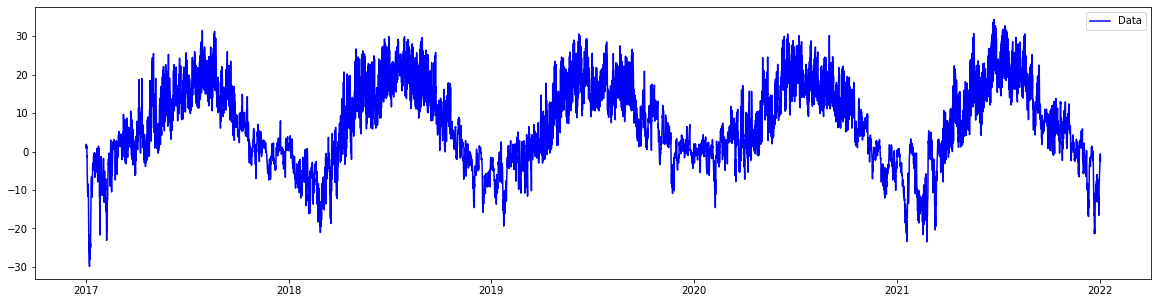

In [6]:
plt.figure(figsize = (20, 5))
plt.plot(data['date'], data['T'], color = 'blue', label = 'Data')
plt.legend()

Начнем с построения базовой модели DecisionTreeRegressor.

In [8]:
# Разобьем данные на обучающую и тестовую выборки
data_train = data[data['date'] < '2020-01-01'] # Обучающая
data_test = data[data['date'] >= '2020-01-01'] # Тестовая

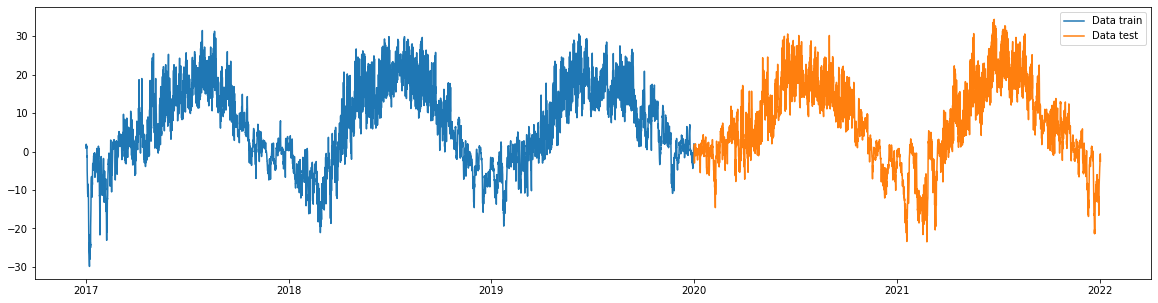

In [9]:
# Визуализируем выборки
plt.figure(figsize = (20, 5))
plt.plot(data_train['date'], data_train['T'], label = 'Data train')
plt.plot(data_test['date'], data_test['T'], label = 'Data test')
plt.legend()

In [10]:
# Будем прогнозировать температуру в зависимости от дня в году
# Создаем новый признак -- день в году
data['dayofyear'] = data['date'].dt.dayofyear
# Заново переразбиваем датасет на train-test, чтобы изменения применились
data_train = data[data['date'] < '2020-01-01']
data_test = data[data['date'] >= '2020-01-01']

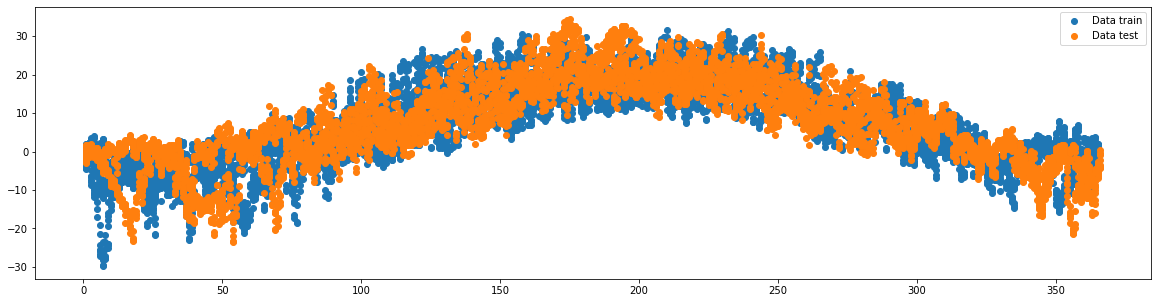

In [11]:
plt.figure(figsize = (20, 5))
plt.scatter(data_train['dayofyear'], data_train['T'], label = 'Data train')
plt.scatter(data_test['dayofyear'], data_test['T'], label = 'Data test')
plt.legend()

In [12]:
import numpy as np # Для математических функций
from sklearn.tree import DecisionTreeRegressor # Алгоритм дерева решений
from sklearn.metrics import mean_squared_error # Для проверки качества (средняя сумма квадратов отклонений)

In [13]:
# Отсечем все лишнее в таблице, оставив только день в году...
X_train = pd.DataFrame()
X_train['dayofyear'] = data_train['dayofyear']
X_test = pd.DataFrame()
X_test['dayofyear'] = data_test['dayofyear']
# ... и температуру
y_train = data_train['T']
y_test = data_test['T']

In [14]:
model = DecisionTreeRegressor()  # Создаем модель
model.fit(X_train, y_train) # Обучаем модель

pred_train = model.predict(X_train) # Прогноз для тренировочных данных
pred_test = model.predict(X_test) # Прогноз на данных, которые модель еще не видела

Суммарная ошибка на обучающей выборке = 20.78417741544515
Суммарная ошибка на тестовой выборке = 34.74021538620518


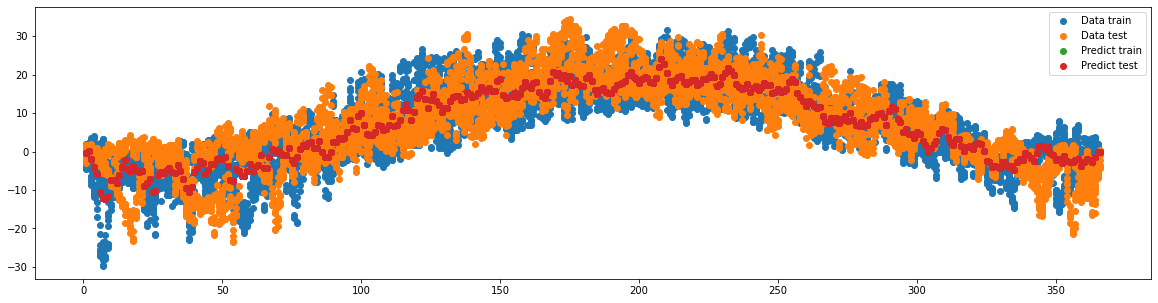

In [15]:
# Визуализируем модель
plt.figure(figsize = (20, 5))
plt.scatter(data_train['dayofyear'], y_train, label = 'Data train')
plt.scatter(data_test['dayofyear'], y_test, label = 'Data test')
plt.scatter(data_train['dayofyear'], pred_train, label = 'Predict train')
plt.scatter(data_test['dayofyear'], pred_test, label = 'Predict test')
plt.legend()

print('Суммарная ошибка на обучающей выборке =', mean_squared_error(y_train, pred_train))
print('Суммарная ошибка на тестовой выборке =', mean_squared_error(y_test, pred_test))

Попробуем улучшить модель, добавив тригонометрическое преобразование признаков.

In [16]:
# Посмотрим, в каком диапазоне находятся данные признака dayofyear
data['dayofyear'].min(), data['dayofyear'].max()

(1, 366)

In [17]:
# Перейдем к интервалу от 0 до 2pi
scaled = ((data['dayofyear'] - 1) / 366 ) * 2 * np.pi

In [18]:
data['cos_dayofyear'] = np.cos(scaled)

In [19]:
# Заново переразбиваем датасет на train-test, чтобы изменения применились
data_train = data[data['date'] < '2020-01-01']
data_test = data[data['date'] >= '2020-01-01']

X_train = pd.DataFrame()
X_train['cos_dayofyear'] = data_train['cos_dayofyear'] 
X_test = pd.DataFrame()
X_test['cos_dayofyear'] = data_test['cos_dayofyear']

y_train = data_train['T']
y_test = data_test['T']

In [20]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

Суммарная ошибка на обучающей выборке = 28.70644792104413
Суммарная ошибка на тестовой выборке = 35.372235479908134


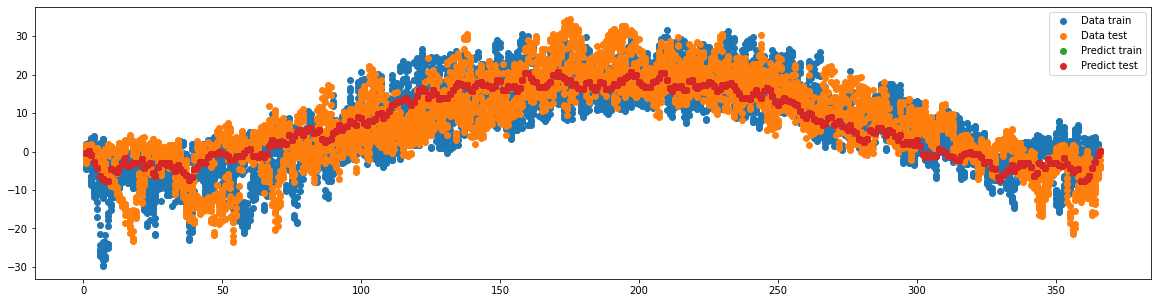

In [21]:
# Визуализируем модель
plt.figure(figsize = (20, 5))
plt.scatter(data_train['dayofyear'], y_train, label = 'Data train')
plt.scatter(data_test['dayofyear'], y_test, label = 'Data test')
plt.scatter(data_train['dayofyear'], pred_train, label = 'Predict train')
plt.scatter(data_test['dayofyear'], pred_test, label = 'Predict test')
plt.legend()

print('Суммарная ошибка на обучающей выборке =', mean_squared_error(y_train, pred_train))
print('Суммарная ошибка на тестовой выборке =', mean_squared_error(y_test, pred_test))

Видим, что средняя сумма квадратов возросла, значит, качество модели ухудшилось. Нужен другой вариант.

Попробуем преобразовать признак не к косинусу, а к синусу.

In [ ]:
data['sin_dayofyear'] = np.sin(scaled)

In [ ]:
# Заново переразбиваем датасет на train-test, чтобы изменения применились
data_train = data[data['date'] < '2020-01-01']
data_test = data[data['date'] >= '2020-01-01']

X_train = pd.DataFrame()
X_train['sin_dayofyear'] = data_train['sin_dayofyear'] 
X_test = pd.DataFrame()
X_test['sin_dayofyear'] = data_test['sin_dayofyear']

y_train = data_train['T']
y_test = data_test['T']

In [ ]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

Суммарная ошибка на обучающей выборке = 98.67171747054093
Суммарная ошибка на тестовой выборке = 108.8844986852078


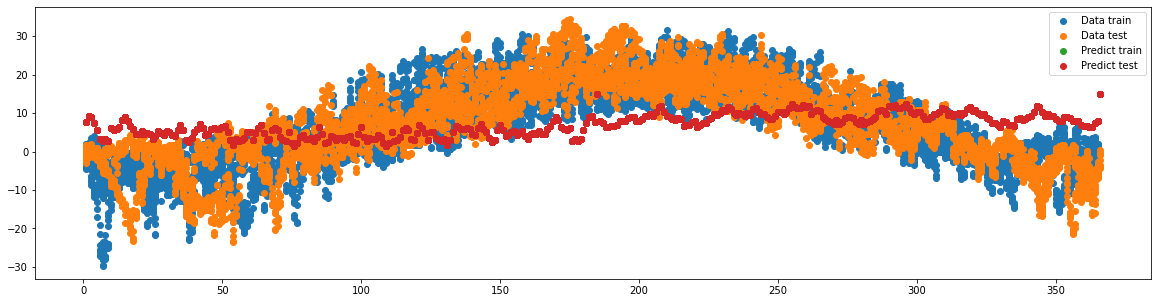

In [ ]:
# Визуализируем модель
plt.figure(figsize = (20, 5))
plt.scatter(data_train['dayofyear'], y_train, label = 'Data train')
plt.scatter(data_test['dayofyear'], y_test, label = 'Data test')
plt.scatter(data_train['dayofyear'], pred_train, label = 'Predict train')
plt.scatter(data_test['dayofyear'], pred_test, label = 'Predict test')
plt.legend()

print('Суммарная ошибка на обучающей выборке =', mean_squared_error(y_train, pred_train))
print('Суммарная ошибка на тестовой выборке =', mean_squared_error(y_test, pred_test))

Видим, что качество модели вообще сильно упало и ее график далек от наших данных.

Попробуем объединить синус и косинус в преобразовании признаков.

In [ ]:
X_train = pd.DataFrame()
X_train['cos_dayofyear'] = data_train['cos_dayofyear']
X_train['sin_dayofyear'] = data_train['sin_dayofyear'] 
X_test = pd.DataFrame()
X_test['cos_dayofyear'] = data_test['cos_dayofyear']
X_test['sin_dayofyear'] = data_test['sin_dayofyear'] 

y_train = data_train['T']
y_test = data_test['T']

In [ ]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

Суммарная ошибка на обучающей выборке = 20.78417741544515
Суммарная ошибка на тестовой выборке = 34.74160569862214


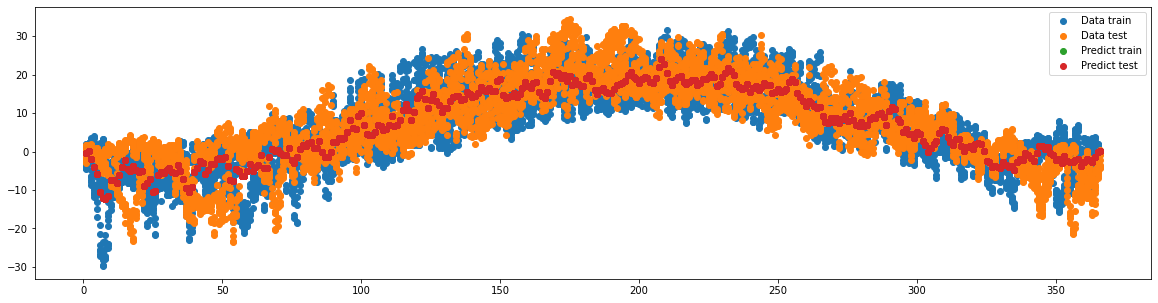

In [ ]:
# Визуализируем модель
plt.figure(figsize = (20, 5))
plt.scatter(data_train['dayofyear'], y_train, label = 'Data train')
plt.scatter(data_test['dayofyear'], y_test, label = 'Data test')
plt.scatter(data_train['dayofyear'], pred_train, label = 'Predict train')
plt.scatter(data_test['dayofyear'], pred_test, label = 'Predict test')
plt.legend()

print('Суммарная ошибка на обучающей выборке =', mean_squared_error(y_train, pred_train))
print('Суммарная ошибка на тестовой выборке =', mean_squared_error(y_test, pred_test))

Модель получилась такая же, как и с непреобразованными данными. Значит, в таком преобразовании нет смысла.

Попробуем построить модель на преобразованном к косинусу признаке и первоначальном.

In [ ]:
X_train = pd.DataFrame()
X_train['cos_dayofyear'] = data_train['cos_dayofyear']
X_train['dayofyear'] = data_train['dayofyear']
X_test = pd.DataFrame()
X_test['cos_dayofyear'] = data_test['cos_dayofyear']
X_test['dayofyear'] = data_test['dayofyear']

y_train = data_train['T']
y_test = data_test['T']

In [ ]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

Суммарная ошибка на обучающей выборке = 20.78417741544515
Суммарная ошибка на тестовой выборке = 34.74021538620518


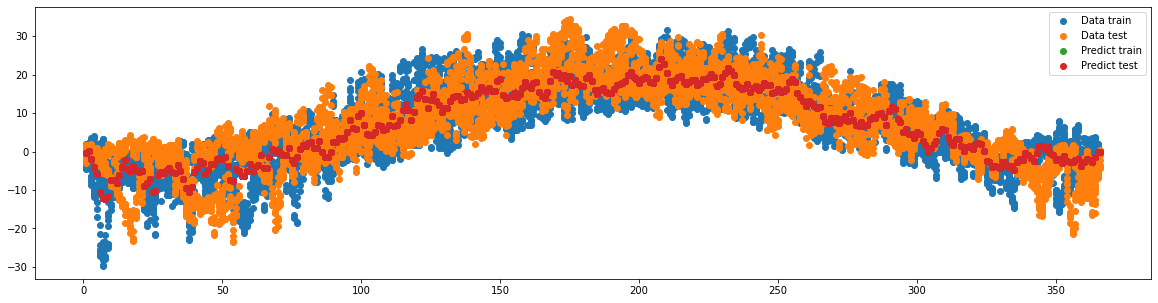

In [ ]:
# Визуализируем модель
plt.figure(figsize = (20, 5))
plt.scatter(data_train['dayofyear'], y_train, label = 'Data train')
plt.scatter(data_test['dayofyear'], y_test, label = 'Data test')
plt.scatter(data_train['dayofyear'], pred_train, label = 'Predict train')
plt.scatter(data_test['dayofyear'], pred_test, label = 'Predict test')
plt.legend()

print('Суммарная ошибка на обучающей выборке =', mean_squared_error(y_train, pred_train))
print('Суммарная ошибка на тестовой выборке =', mean_squared_error(y_test, pred_test))

Снова модель не отличается по качеству от самой первой, в которой не было преобразований.

Попробуем поменять параметры регрессора в первоначальной модели.

In [ ]:
X_train = pd.DataFrame()
X_train['dayofyear'] = data_train['dayofyear']
X_test = pd.DataFrame()
X_test['dayofyear'] = data_test['dayofyear']

y_train = data_train['T']
y_test = data_test['T']

In [ ]:
model = DecisionTreeRegressor(max_depth = 5)
model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

Суммарная ошибка на обучающей выборке = 23.335004953291776
Суммарная ошибка на тестовой выборке = 32.83780557079754


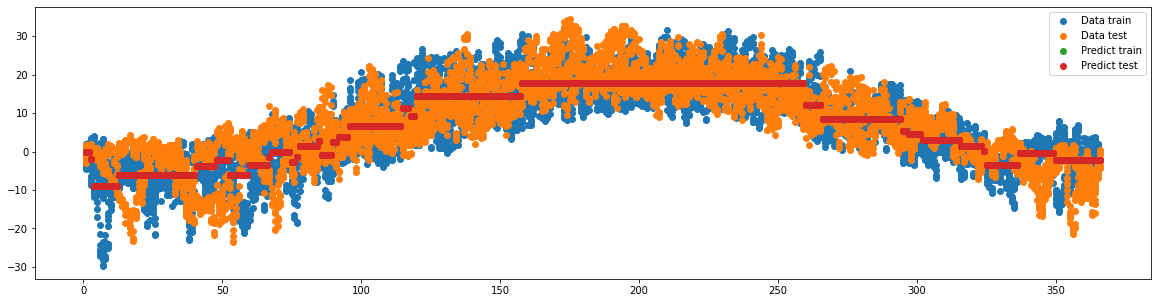

In [ ]:
# Визуализируем модель
plt.figure(figsize = (20, 5))
plt.scatter(data_train['dayofyear'], y_train, label = 'Data train')
plt.scatter(data_test['dayofyear'], y_test, label = 'Data test')
plt.scatter(data_train['dayofyear'], pred_train, label = 'Predict train')
plt.scatter(data_test['dayofyear'], pred_test, label = 'Predict test')
plt.legend()

print('Суммарная ошибка на обучающей выборке =', mean_squared_error(y_train, pred_train))
print('Суммарная ошибка на тестовой выборке =', mean_squared_error(y_test, pred_test))

Видим, что на тестовой выборке качество модели стало лучше, но ухудшился прогноз обучающей выборки. Возможно, нам нужно другое значение параметра. Попробуем найти оптимальное.

In [ ]:
best_score = 0.0
best_md = -1
for md in range(1, 11):
    model = DecisionTreeRegressor(max_depth = md)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    if score > best_score:
        best_md = md
        best_score = score
        
print("Лучшее значение параметра max_depth =", best_md)

Лучшее значение параметра max_depth = 6


Создадим модель с лучшим значением параметра.

In [ ]:
model = DecisionTreeRegressor(max_depth = 6)
model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

Суммарная ошибка на обучающей выборке = 22.598112484132102
Суммарная ошибка на тестовой выборке = 32.827361933209865


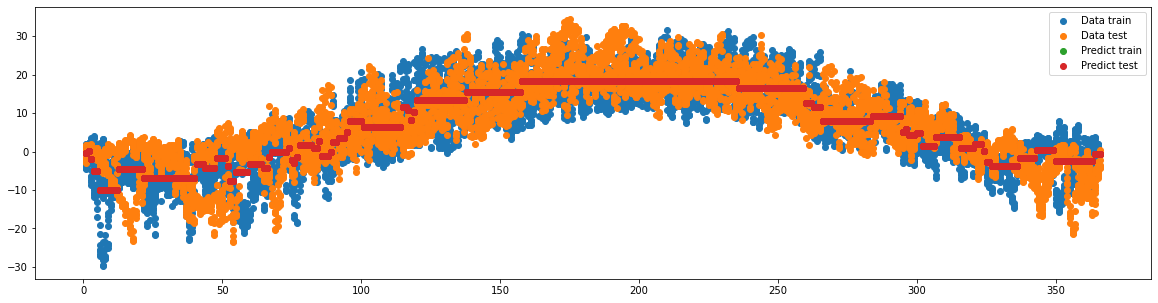

In [ ]:
# Визуализируем модель
plt.figure(figsize = (20, 5))
plt.scatter(data_train['dayofyear'], y_train, label = 'Data train')
plt.scatter(data_test['dayofyear'], y_test, label = 'Data test')
plt.scatter(data_train['dayofyear'], pred_train, label = 'Predict train')
plt.scatter(data_test['dayofyear'], pred_test, label = 'Predict test')
plt.legend()

print('Суммарная ошибка на обучающей выборке =', mean_squared_error(y_train, pred_train))
print('Суммарная ошибка на тестовой выборке =', mean_squared_error(y_test, pred_test))

Вывод:

Из всех экспериментов самой удачной оказалась модель, основанная на непреобразованных признаках, с параметром max_depth = 6. Она дает лучшее качество прогноза на тестовой выборке, хоть и немного проигрывает в прогнозе на обучающей выборке.